# RNA Energy Barriers Exploration

This notebook explores the implementation of RNA structure manipulation and path finding algorithms.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG, display

import RNA #pip install viennarna

from src.rna_structure import RNAStructure
from src.path_finding import find_indirect_path, find_best_indirect_path
from src.energy import base_pair_minimization_energy, turner_energy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Testing Indirect Path Finding

In [46]:
# Define start and end structures
sequence = "GGGGAAACUCC"
start_struct = "(..(...)..)"
end_struct = "...((...).)"  # A different valid structure

RNA.svg_rna_plot(sequence, structure=start_struct, ssfile="tmp_start.svg")
RNA.svg_rna_plot(sequence, structure=end_struct, ssfile="tmp_end.svg")

start = RNAStructure(sequence, start_struct)
end = RNAStructure(sequence, end_struct)

#display(SVG("tmp_start.svg"), SVG("tmp_end.svg"))

# Find direct path
indirect_path = find_indirect_path(start, end)
print("Direct path:")
for i, struct in enumerate(indirect_path):
    print(f"Step {i}: {struct.to_dotbracket()}")
   


Direct path:
Step 0: (..(...)..)
Step 1: ...(...)...
Step 2: ..((...))..
Step 3: ..(.....)..
Step 4: ...........
Step 5: ...(......)
Step 6: ...((...).)


## 4. Analyzing Energy Barriers

For now, we're using a simple energy model (negative number of base pairs). Later we'll integrate with ViennaRNA for more accurate energy calculations.

In [47]:
def plot_energy_profile(energies):      
    plt.figure(figsize=(10, 6))
    plt.plot(energies, '-o')
    plt.xlabel('Step')
    plt.ylabel('Energy')
    plt.title('Energy Profile Along Folding Path')
    plt.grid(True)
    plt.show()
    
    return max(energies) - energies[0]  # barrier height

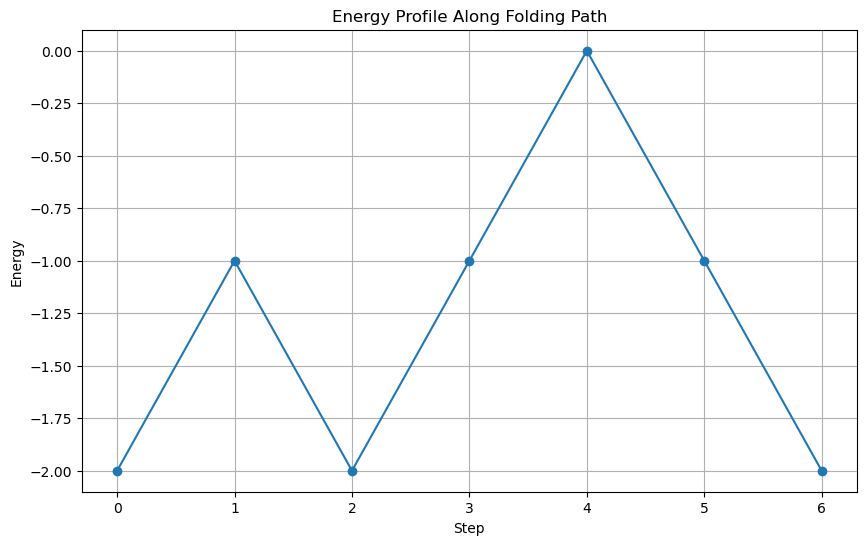

Indirect path barrier: 2


In [48]:
bpm_energies = [base_pair_minimization_energy(s) for s in indirect_path]
print("Indirect path barrier:", plot_energy_profile(bpm_energies))

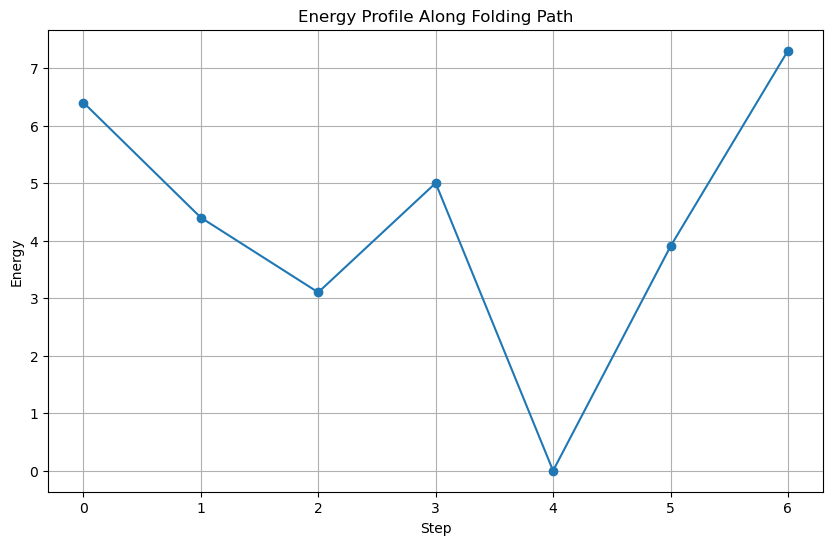

0.9000000953674316

In [49]:
fold_compound = RNA.fold_compound(sequence)
turner_energies = [turner_energy(fold_compound, s.to_dotbracket()) for s in indirect_path]

plot_energy_profile(turner_energies)

## 5. Testing longer example as with indirect heuristic

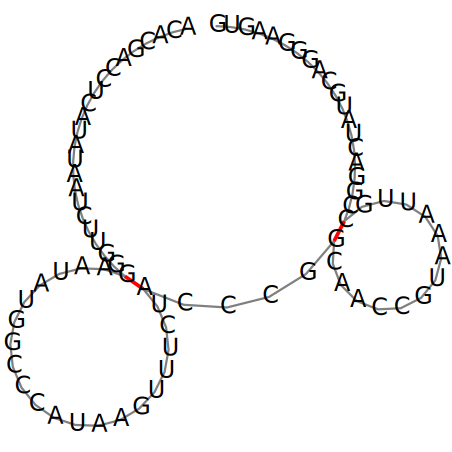

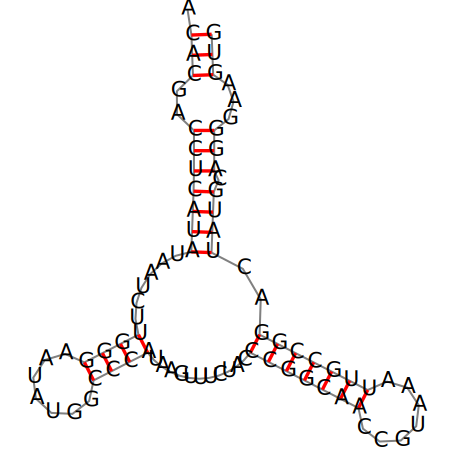

Base pair distance between structures: 21
Starting indirect path attempt 1/5
Attempt 1: path length = 46, energy barrier = 0.00
New best barrier: 0.00
Starting indirect path attempt 2/5
Attempt 2: path length = 54, energy barrier = 100007.20
Starting indirect path attempt 3/5
Attempt 3: path length = 56, energy barrier = 1.70
Starting indirect path attempt 4/5
Attempt 4: path length = 46, energy barrier = 1.80
Starting indirect path attempt 5/5
Attempt 5: path length = 1214, energy barrier = 299989.81
Direct path lenth: 46


In [50]:
# Define start and end structures
seq = "ACACGACCUCAUAUAAUCUUGGGAAUAUGGCCCAUAAGUUUCUACCCGGCAACCGUAAAUUGCCGGACUAUGCAGGGAAGUG"
start_struct = "......................(....................)....(.............)..................."
end_struct = ".(((..(((((((......((((.......))))...........(((((((.......)))))))..)))).)))...)))"  # target structure

RNA.svg_rna_plot(seq, structure=start_struct, ssfile="tmp_start.svg")
RNA.svg_rna_plot(seq, structure=end_struct, ssfile="tmp_end.svg")

start = RNAStructure(seq, start_struct)
end = RNAStructure(seq, end_struct)

display(SVG("tmp_start.svg"), SVG("tmp_end.svg"))

# Find direct path
best_indirect_path = find_best_indirect_path(start, end)
print(f"Direct path lenth: {len(best_indirect_path)}")

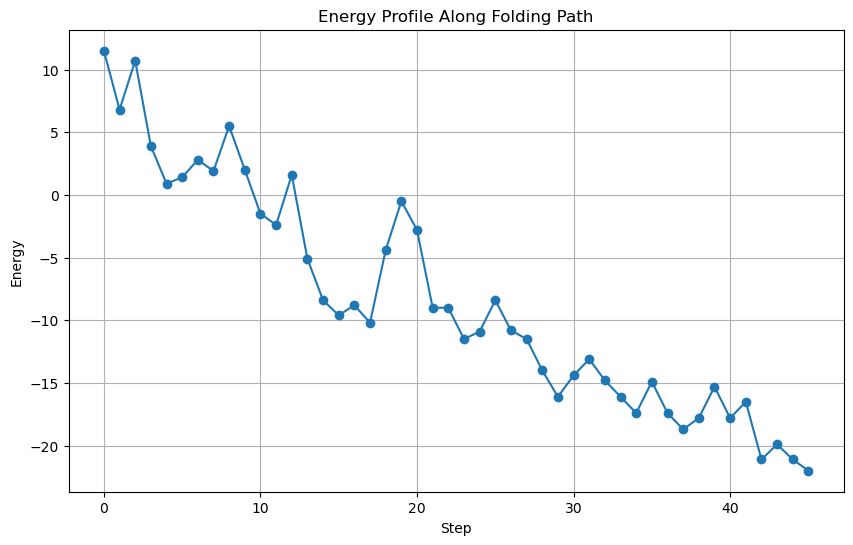

0.0

In [51]:
fold_compound = RNA.fold_compound(seq)
turner_energies = [turner_energy(fold_compound, s.to_dotbracket()) for s in best_indirect_path]

plot_energy_profile(turner_energies)